In [1]:
import random
import glob
from importlib import reload
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import seaborn as sn
import time
import frame_loader as frame_loader
import utils as utils
import augmentation as augmentation
import graph_neural_network
from typing import  List

import numpy as np
import math
import pandas as pd
from pandas import DataFrame
from scipy.spatial import distance as distance_calculator
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
import frame_loader as frame_loader
import gc

#### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reduced_cols = ['doppler','snr','x','y','current_frame','Label']
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq', 'Label']
selected_cols = ['doppler','snr','x','y']
SHAPE_NAMES = [0,1,2,3,4, 5]
frame_depths = [10,10,10,10,10,10,10,10,10,10] 
ks = [2]
num_chunks = 16
lr = 0.001
max_epoch = 50
size = 64
split = 64
EARLY_STOPPING_PATIENCE = 10
# train, val, test =[],[],[]

#### Pre-processing pipeline

File read
Total number of frames: 23442
Number of graphs generated with k = 4 and frame depth = 8 for type 0: 7467
Number of graphs generated with k = 4 and frame depth = 8 for type 1: 1318
Number of graphs generated with k = 4 and frame depth = 8 for type 2: 1355
trained: 0


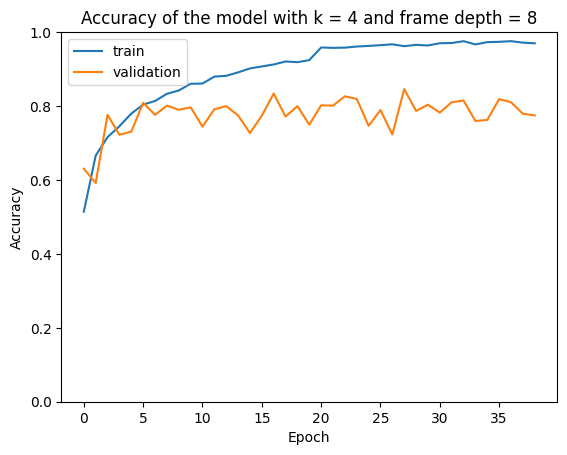

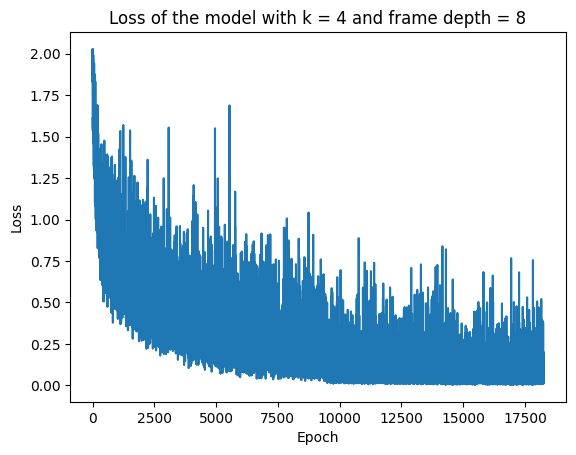

Training accuracy: 0.9697334940404446
Training loss: 0.10878036
Accuracy of the model with k = 4 and frame depth = 8: 0.7747
--- 1204.1439838409424 seconds ---
evaluated: 0
Val accuracy of the model with k = 4 and frame depth = 8: 0.8460


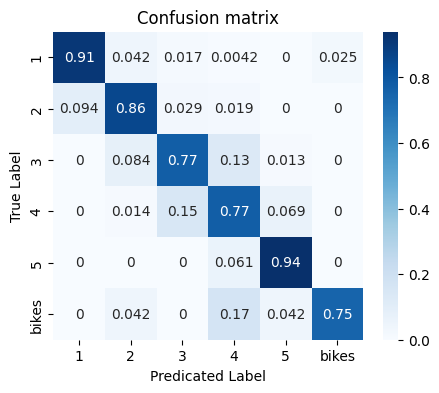

Test accuracy of the model with k = 4 and frame depth = 8: 0.7948


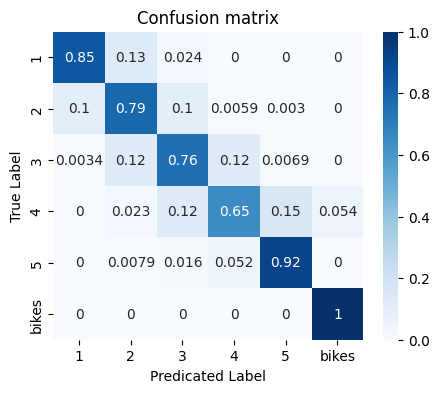

In [3]:
reload(utils)
try:
    point_frames = pd.read_csv("data/all_data.csv", names=column_names, header=None, dtype=np.float64)
    print("File read")
except Exception as e:
    point_frames = frame_loader.load_original_frames()
    print("Frames generated")

all_data_grouped = point_frames[reduced_cols].groupby("current_frame")
print("Total number of frames: "+str(len(all_data_grouped)))
data_array = [frame.to_numpy() for (_, frame) in all_data_grouped]

# Sort the data
sorted_data = sorted(data_array,key=lambda x:x[:,4].max(axis=0))

# Split the data
train, val, test = utils.split_with_chunks_list(sorted_data, SHAPE_NAMES, num_chunks, 0.15, 0.15)

for k in ks:
    for fd in frame_depths:
        results = np.empty(4)

        train_graphs, val_graphs, test_graphs = utils.load_graphs(train, val, test, [fd], [k], selected_cols, \
                                                          num_chunks, size, split, device, mode="random")
        
        results[0] = len(train_graphs[0])
        
        augmentation_transformer = augmentation.AugmentationTransformerList(size)
        augmented_graphs = augmentation_transformer(train_graphs[0])
        train_graphs[0].extend(augmented_graphs)

        train_dataloaders = []
        test_dataloaders = []
        val_dataloaders = []

        # Batch the sets
        for i in range(len(train_graphs)):
            random.seed(42)
            random.shuffle(train_graphs[i])
            random.seed(42)
            random.shuffle(test_graphs[i])
            random.seed(42)
            random.shuffle(val_graphs[i])
            
            train_dataloaders.append(DataLoader(train_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
            test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
            val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
        

        for i, train_dataloader in enumerate(train_dataloaders):
            val_accuracies = []
            start_time = time.time()
            # k = ks[i % len(ks)]
            model = graph_neural_network.Net(6, k=k).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

            best_acc = -1
            losses = []
            accuracies = []
            for epoch in range(max_epoch):
                correct = 0
                count = 0
                model.train()
                for train_batch in train_dataloader:
                    train_batch = train_batch.to(device)
                    optimizer.zero_grad()
                    out = model(train_batch)
                    pred = out.argmax(dim=1)
                    correct += (pred == train_batch.y).sum()
                    loss = F.nll_loss(out, train_batch.y)
                    losses.append(loss.detach())
                    loss.backward()
                    optimizer.step()
                    count += len(train_batch)
                acc = int(correct) / count
                losses.append(loss.detach())
                accuracies.append(acc)
                scheduler.step()

                model.eval()
                val_correct = 0
                for val_batch in val_dataloaders[i]:
                    val_batch = val_batch.to(device)
                    pred = model(val_batch).argmax(dim=1)
                    
                    val_correct += (pred == val_batch.y).sum()
                val_acc = int(val_correct) / len(val_dataloaders[i].dataset)
                val_accuracies.append(val_acc)

                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = model
                    torch.save(model, f"data/trained_model_k{k}_frame_depth{fd}_random_maxaggr.pt")
                    last_improvement = 0
                else:
                    last_improvement += 1

                if last_improvement > EARLY_STOPPING_PATIENCE:
                    break
            
            losses = [tensor.cpu().numpy() for tensor in losses]
            print(f"trained: {i}")

            plt.plot(accuracies, label = "train")
            plt.plot(val_accuracies, label = "validation")
            plt.title(f"Accuracy of the model with k = {k} and frame depth = {fd}")
            plt.ylabel("Accuracy")
            plt.xlabel("Epoch")
            plt.ylim(0,1)
            plt.legend() 
            plt.show()

            plt.plot(losses)
            plt.title(f"Loss of the model with k = {k} and frame depth = {fd}")
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            plt.show()

            print("Training accuracy: "+str(accuracies[-1]))
            print("Training loss: "+str(losses[-1]))
            
            print(f'Accuracy of the model with k = {k} and frame depth = {fd}: {val_accuracies[-1]:.4f}')
            results[1] = time.time() - start_time
            print("--- %s seconds ---" % (time.time() - start_time))
            print(f"evaluated: {i}")

        best_model = torch.load( f"data/trained_model_k{k}_frame_depth{fd}_random_maxaggr.pt")
        best_model.eval()
        total_y_pred_label = []
        total_y_true_label = []
        correct = 0
        for test_batch in val_dataloaders[i]:
            test_batch = test_batch.to(device)
            pred = best_model(test_batch).argmax(dim=1)
            
            total_y_pred_label.extend(pred)
            total_y_true_label.extend(test_batch.y)
            
            correct += (pred == test_batch.y).sum()
        acc = int(correct) / len(val_graphs[i])
        print(f'Val accuracy of the model with k = {k} and frame depth = {fd}: {acc:.4f}')
        results[2] = acc

        SHAPE_LABELS = [1,2,3,4,5,"bikes"]
        total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
        total_y_true = [true_label.item() for true_label in total_y_true_label]
        cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

        df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
                    columns = SHAPE_LABELS)
        plt.figure(figsize = (5,4))
        plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
        figure = plot.get_figure()
        plt.title("Confusion matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicated Label')
        plt.show()

        best_model.eval()
        total_y_pred_label = []
        total_y_true_label = []
        correct = 0
        for test_batch in test_dataloaders[i]:
            test_batch = test_batch.to(device)
            pred = best_model(test_batch).argmax(dim=1)
            
            total_y_pred_label.extend(pred)
            total_y_true_label.extend(test_batch.y)
            
            correct += (pred == test_batch.y).sum()
        test_acc = int(correct) / len(test_graphs[i])
        print(f'Test accuracy of the model with k = {k} and frame depth = {fd}: {test_acc:.4f}')
        results[3] = test_acc

        np.save(f"data/results_k{k}_frame_depth{fd}_random_maxaggr.npy", results)

        SHAPE_LABELS = [1,2,3,4,5,"bikes"]
        total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
        total_y_true = [true_label.item() for true_label in total_y_true_label]
        cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

        df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
                    columns = SHAPE_LABELS)
        plt.figure(figsize = (5,4))
        plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
        figure = plot.get_figure()
        plt.title("Confusion matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicated Label')
        plt.show()

        del train_graphs
        del val_graphs
        del test_graphs
        del train_dataloaders
        del val_dataloaders
        del test_dataloaders
        del model
        del best_model
        
        gc.collect()
        torch.cuda.empty_cache()


In [31]:
res = np.load("data/results_k8_frame_depth10_random.npy")
print([f"{r:.4f}" for r in res])

['5700.0000', '823.0458', '0.8262', '0.7569']


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reduced_cols = ['doppler','snr','x','y','current_frame','Label']
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq', 'Label']
selected_cols = ['doppler','snr','x','y']
SHAPE_NAMES = [0,1,2,3,4, 5]
frame_depths = [12] 
ks = [2,4,8]
num_chunks = 16
lr = 0.001
max_epoch = 50
size = 64
split = 64
EARLY_STOPPING_PATIENCE = 10

File read


Total number of frames: 23442
Number of graphs generated with k = 2 and frame depth = 12 for type 0: 5086
Number of graphs generated with k = 2 and frame depth = 12 for type 1: 794
Number of graphs generated with k = 2 and frame depth = 12 for type 2: 824
trained: 0


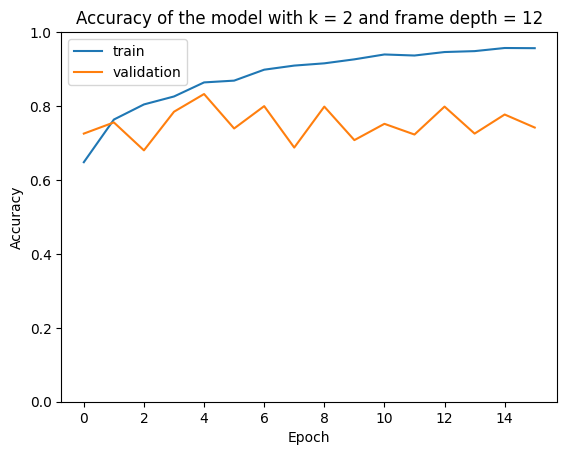

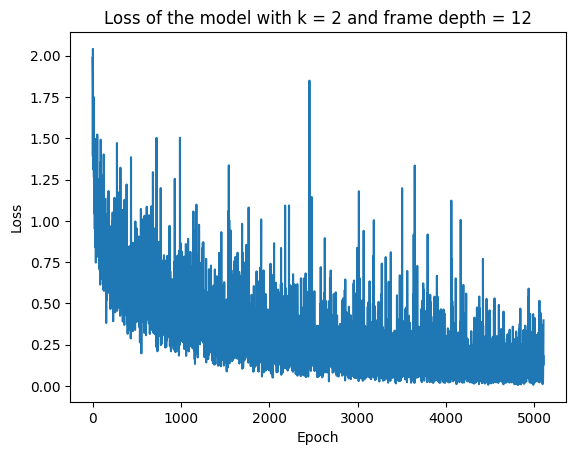

Training accuracy: 0.956547384978372
Training loss: 0.39783663
Accuracy of the model with k = 2 and frame depth = 12: 0.7418
--- 347.9151244163513 seconds ---
evaluated: 0
Val accuracy of the model with k = 2 and frame depth = 12: 0.8325


/tmp/ipykernel_870875/1495547130.py:148: RuntimeWarning: invalid value encountered in divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


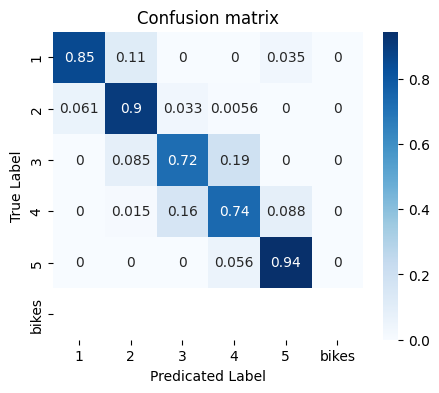

Test accuracy of the model with k = 2 and frame depth = 12: 0.8070


/tmp/ipykernel_870875/1495547130.py:182: RuntimeWarning: invalid value encountered in divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


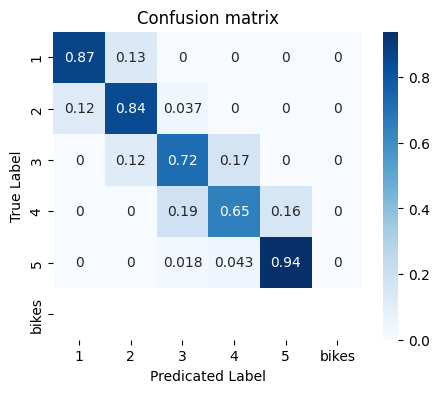

Number of graphs generated with k = 4 and frame depth = 12 for type 0: 4886
Number of graphs generated with k = 4 and frame depth = 12 for type 1: 753
Number of graphs generated with k = 4 and frame depth = 12 for type 2: 796
trained: 0


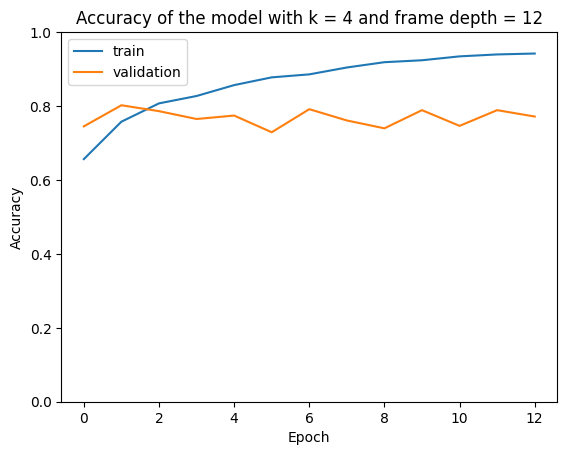

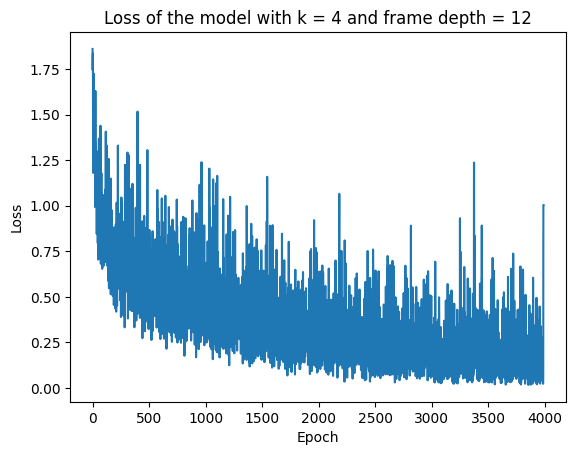

Training accuracy: 0.9420794105607859
Training loss: 1.0037556
Accuracy of the model with k = 4 and frame depth = 12: 0.7716
--- 384.97897148132324 seconds ---
evaluated: 0
Val accuracy of the model with k = 4 and frame depth = 12: 0.8021


/tmp/ipykernel_870875/1495547130.py:148: RuntimeWarning: invalid value encountered in divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


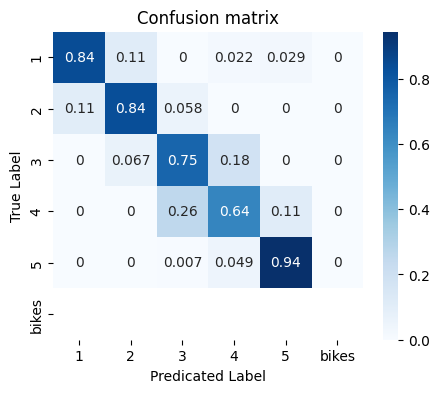

Test accuracy of the model with k = 4 and frame depth = 12: 0.8103


/tmp/ipykernel_870875/1495547130.py:182: RuntimeWarning: invalid value encountered in divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


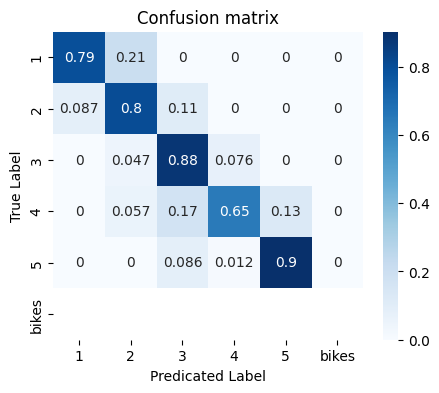

Number of graphs generated with k = 8 and frame depth = 12 for type 0: 4600
Number of graphs generated with k = 8 and frame depth = 12 for type 1: 704
Number of graphs generated with k = 8 and frame depth = 12 for type 2: 746
trained: 0


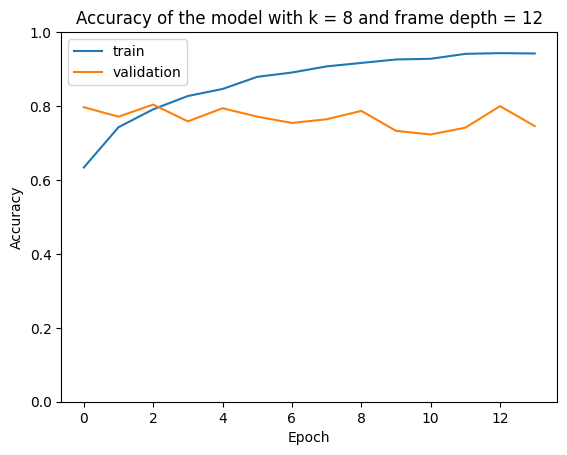

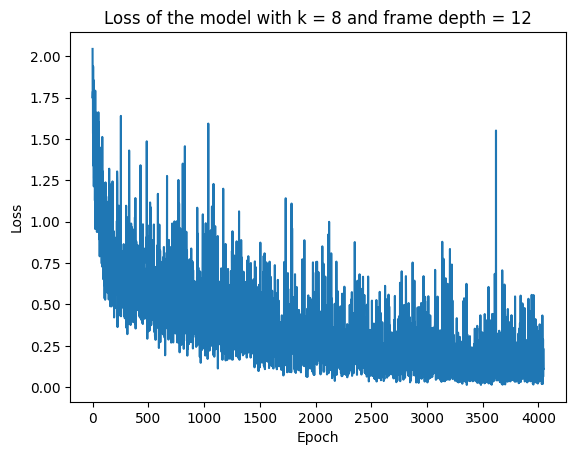

Training accuracy: 0.9421739130434783
Training loss: 0.1096004
Accuracy of the model with k = 8 and frame depth = 12: 0.7457
--- 658.9038441181183 seconds ---
evaluated: 0
Val accuracy of the model with k = 8 and frame depth = 12: 0.8040


/tmp/ipykernel_870875/1495547130.py:148: RuntimeWarning: invalid value encountered in divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


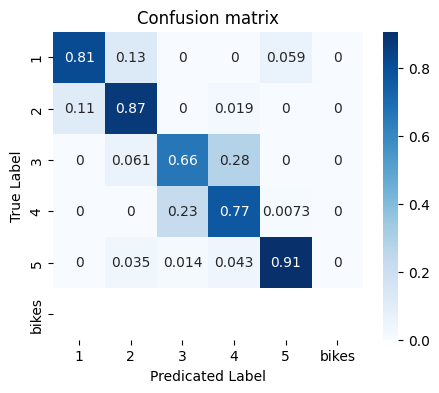

Test accuracy of the model with k = 8 and frame depth = 12: 0.7842


/tmp/ipykernel_870875/1495547130.py:182: RuntimeWarning: invalid value encountered in divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


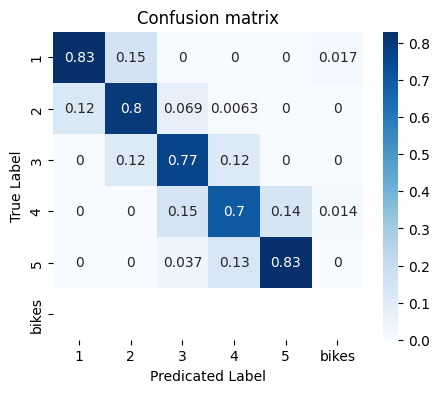

In [5]:
try:
    point_frames = pd.read_csv("data/all_data.csv", names=column_names, header=None, dtype=np.float64)
    print("File read")
except Exception as e:
    point_frames = frame_loader.load_original_frames()
    print("Frames generated")

all_data_grouped = point_frames[reduced_cols].groupby("current_frame")
print("Total number of frames: "+str(len(all_data_grouped)))
data_array = [frame.to_numpy() for (_, frame) in all_data_grouped]

# Sort the data
sorted_data = sorted(data_array,key=lambda x:x[:,4].max(axis=0))

# Split the data
train, val, test = utils.split_with_chunks_list(sorted_data, SHAPE_NAMES, num_chunks, 0.15, 0.15)

for k in ks:
    for fd in frame_depths:
        results = np.empty(4)

        train_graphs, val_graphs, test_graphs = utils.load_graphs(train, val, test, [fd], [k], selected_cols, \
                                                          num_chunks, size, split, device, mode="desc")
        
        results[0] = len(train_graphs[0])
        
        augmentation_transformer = augmentation.AugmentationTransformerList(size)
        augmented_graphs = augmentation_transformer(train_graphs[0])
        train_graphs[0].extend(augmented_graphs)

        train_dataloaders = []
        test_dataloaders = []
        val_dataloaders = []

        # Batch the sets
        for i in range(len(train_graphs)):
            random.seed(42)
            random.shuffle(train_graphs[i])
            random.seed(42)
            random.shuffle(test_graphs[i])
            random.seed(42)
            random.shuffle(val_graphs[i])
            
            train_dataloaders.append(DataLoader(train_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
            test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
            val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
        

        for i, train_dataloader in enumerate(train_dataloaders):
            val_accuracies = []
            start_time = time.time()
            # k = ks[i % len(ks)]
            model = graph_neural_network.Net(6, k=k).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

            best_acc = -1
            losses = []
            accuracies = []
            for epoch in range(max_epoch):
                correct = 0
                count = 0
                model.train()
                for train_batch in train_dataloader:
                    train_batch = train_batch.to(device)
                    optimizer.zero_grad()
                    out = model(train_batch)
                    pred = out.argmax(dim=1)
                    correct += (pred == train_batch.y).sum()
                    loss = F.nll_loss(out, train_batch.y)
                    losses.append(loss.detach())
                    loss.backward()
                    optimizer.step()
                    count += len(train_batch)
                acc = int(correct) / count
                losses.append(loss.detach())
                accuracies.append(acc)
                scheduler.step()

                model.eval()
                val_correct = 0
                for val_batch in val_dataloaders[i]:
                    val_batch = val_batch.to(device)
                    pred = model(val_batch).argmax(dim=1)
                    
                    val_correct += (pred == val_batch.y).sum()
                val_acc = int(val_correct) / len(val_dataloaders[i].dataset)
                val_accuracies.append(val_acc)

                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = model
                    torch.save(model, f"data/trained_model_k{k}_frame_depth{fd}_max.pt")
                    last_improvement = 0
                else:
                    last_improvement += 1

                if last_improvement > EARLY_STOPPING_PATIENCE:
                    break
            
            losses = [tensor.cpu().numpy() for tensor in losses]
            print(f"trained: {i}")

            plt.plot(accuracies, label = "train")
            plt.plot(val_accuracies, label = "validation")
            plt.title(f"Accuracy of the model with k = {k} and frame depth = {fd}")
            plt.ylabel("Accuracy")
            plt.xlabel("Epoch")
            plt.ylim(0,1)
            plt.legend() 
            plt.show()

            plt.plot(losses)
            plt.title(f"Loss of the model with k = {k} and frame depth = {fd}")
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            plt.show()

            print("Training accuracy: "+str(accuracies[-1]))
            print("Training loss: "+str(losses[-1]))
            
            print(f'Accuracy of the model with k = {k} and frame depth = {fd}: {val_accuracies[-1]:.4f}')
            results[1] = time.time() - start_time
            print("--- %s seconds ---" % (time.time() - start_time))
            print(f"evaluated: {i}")

        best_model = torch.load( f"data/trained_model_k{k}_frame_depth{fd}_max.pt")
        best_model.eval()
        total_y_pred_label = []
        total_y_true_label = []
        correct = 0
        for test_batch in val_dataloaders[i]:
            test_batch = test_batch.to(device)
            pred = best_model(test_batch).argmax(dim=1)
            
            total_y_pred_label.extend(pred)
            total_y_true_label.extend(test_batch.y)
            
            correct += (pred == test_batch.y).sum()
        acc = int(correct) / len(val_graphs[i])
        print(f'Val accuracy of the model with k = {k} and frame depth = {fd}: {acc:.4f}')
        results[2] = acc

        SHAPE_LABELS = [1,2,3,4,5,"bikes"]
        total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
        total_y_true = [true_label.item() for true_label in total_y_true_label]
        cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

        df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
                    columns = SHAPE_LABELS)
        plt.figure(figsize = (5,4))
        plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
        figure = plot.get_figure()
        plt.title("Confusion matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicated Label')
        plt.show()

        best_model.eval()
        total_y_pred_label = []
        total_y_true_label = []
        correct = 0
        for test_batch in test_dataloaders[i]:
            test_batch = test_batch.to(device)
            pred = best_model(test_batch).argmax(dim=1)
            
            total_y_pred_label.extend(pred)
            total_y_true_label.extend(test_batch.y)
            
            correct += (pred == test_batch.y).sum()
        test_acc = int(correct) / len(test_graphs[i])
        print(f'Test accuracy of the model with k = {k} and frame depth = {fd}: {test_acc:.4f}')
        results[3] = test_acc

        np.save(f"data/results_k{k}_frame_depth{fd}_max.npy", results)

        SHAPE_LABELS = [1,2,3,4,5,"bikes"]
        total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
        total_y_true = [true_label.item() for true_label in total_y_true_label]
        cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

        df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
                    columns = SHAPE_LABELS)
        plt.figure(figsize = (5,4))
        plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
        figure = plot.get_figure()
        plt.title("Confusion matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicated Label')
        plt.show()

        del train_graphs
        del val_graphs
        del test_graphs
        del train_dataloaders
        del val_dataloaders
        del test_dataloaders
        del model
        del best_model
        
        gc.collect()
        torch.cuda.empty_cache()

In [3]:
reload(frame_loader)
reload(utils)
# Load equal frames
# try:
#     point_frames = pd.read_csv(f"data/frames_{size}points_all_varied_fixed.csv", names=column_names, header=None, dtype=np.float64)
#     print("File read")
# except Exception as e:
#     point_frames = frame_loader.equal_frame_loader(column_names,size)
#     print("Frames generated")

try:
    point_frames = pd.read_csv("data/all_data.csv", names=column_names, header=None, dtype=np.float64)
    print("File read")
except Exception as e:
    point_frames = frame_loader.load_original_frames()
    print("Frames generated")

# Normalize the data
# norm_frames = utils.min_max_normalization(point_frames, selected_cols)

# group the data by frame numbers
all_data_grouped = point_frames[reduced_cols].groupby("current_frame")
print("Total number of frames: "+str(len(all_data_grouped)))
data_array = [frame.to_numpy() for (_, frame) in all_data_grouped]

# Sort the data
sorted_data = sorted(data_array,key=lambda x:x[:,4].max(axis=0))
# xy_sorted = [sorted(x,key=lambda x:[x[3], x[2]]) for x in sorted_data]
# xy_dist = [x[:,2]+x[:,3] for x in sorted_data]
# xy_sort_index = [d.argsort() for d in xy_dist]
# xy_sorted = np.array([frame[xy_sort_index[i]] for i, frame in enumerate(sorted_data)])

# Split the data
train, val, test = utils.split_with_chunks_list(sorted_data, SHAPE_NAMES, num_chunks, 0.15, 0.15)


File read
Total number of frames: 23442


In [23]:
losswefes = 0

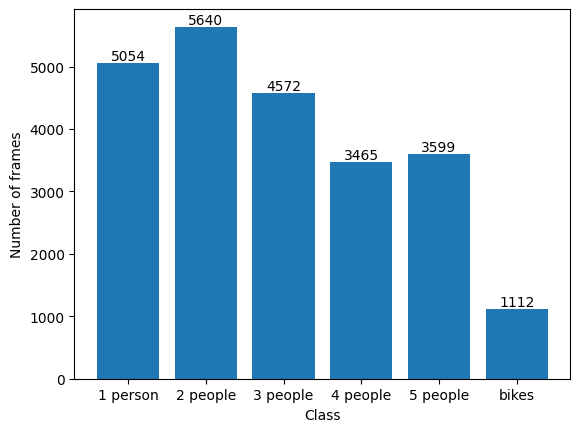

In [17]:
# data_points = np.array([data[0,5] for data in sorted_data])
# zeros = len(np.where(data_points  == 0)[0])
# ones = len(np.where(data_points  == 1)[0])
# twos = len(np.where(data_points  == 2)[0])
# threes = len(np.where(data_points  == 3)[0]) 
# fours = len(np.where(data_points  == 4)[0])
# fives = len(np.where(data_points  == 5)[0])

labels = [ "1 person","2 people","3 people","4 people", "5 people","bikes"]
sample_num = [zeros, ones, twos, threes, fours, fives]
p = plt.bar(labels, sample_num)
plt.xticks(ticks=[0,1,2,3,4,5], labels=labels)
plt.xlabel("Class")
plt.ylabel("Number of frames")
plt.bar_label(p)
plt.show()

In [ ]:
reload(utils)

# Create graphs for each sets with each hyperparameter combination
train_graphs, val_graphs, test_graphs = utils.load_graphs(train, val, test, frame_depths, ks, selected_cols, \
                                                          num_chunks, size, split, device, mode="desc")

#### Data augmentation

In [5]:
reload(augmentation)
    
# augment with random graphs
augmentation_transformer = augmentation.AugmentationTransformerList(size)
# four_graph_loc = np.array([data.y.cpu() == 3 for data in train_graphs[0]])
# four_index = np.where(four_graph_loc)[0].tolist()
# four_graphs = [train_graphs[0][i] for i in four_index]

# bike_graph_loc = np.array([data.y.cpu() == 5 for data in train_graphs[0]])
# bike_index = np.where(bike_graph_loc)[0].tolist()
# bike_graphs = [train_graphs[0][i] for i in bike_index]

# indexes = np.arange(len(train_graphs[0])).tolist()
# random.seed(42)
# sample_train = random.sample(indexes, 1000)
# sample_train = [train_graphs[0][i] for i in sample_train]

augmented_graphs = augmentation_transformer(train_graphs[0])
train_graphs[0].extend(augmented_graphs)

# # augment with random graphs from 4 people
# indexes = np.arange(len(four_graphs)).tolist()
# random.seed(42)
# sample_four = random.sample(indexes, 500)
# sample_four = [four_graphs[i] for i in sample_four]

# augmented_four = augmentation_transformer(sample_four)
# train_graphs[0].extend(augmented_four)

# # augment with random graphs from bikes
# indexes = np.arange(len(bike_graphs)).tolist()
# random.seed(42)
# sample_bike = random.sample(indexes, 100)
# sample_bike = [bike_graphs[i] for i in sample_bike]

# augmented_bike = augmentation_transformer(sample_bike)
# train_graphs[0].extend(augmented_bike)


In [6]:
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Batch the sets
for i in range(len(train_graphs)):
    random.seed(42)
    random.shuffle(train_graphs[i])
    random.seed(42)
    random.shuffle(test_graphs[i])
    random.seed(42)
    random.shuffle(val_graphs[i])
    
    train_dataloaders.append(DataLoader(train_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))


#### Train the model

trained: 0


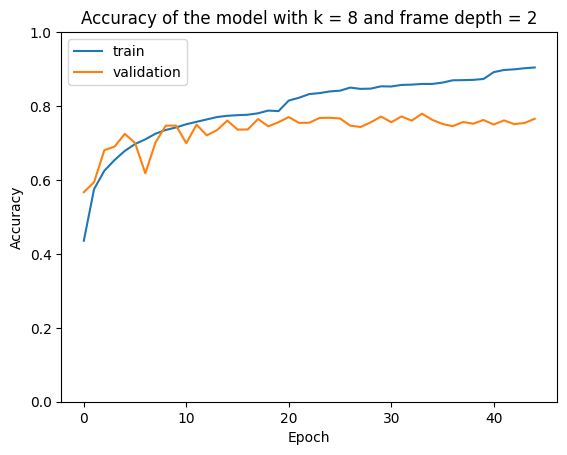

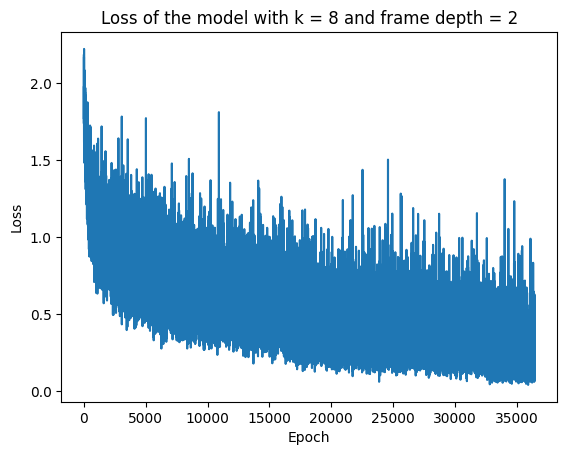

Training accuracy: 0.9043293390027058
Training loss: 0.38802776
Accuracy of the model with k = 8 and frame depth = 2: 0.7656
--- 1337.4992747306824 seconds ---
evaluated: 0


In [7]:
reload(graph_neural_network)
models = []

for i, train_dataloader in enumerate(train_dataloaders):
    val_accuracies = []
    start_time = time.time()
    k = ks[i % len(ks)]
    model = graph_neural_network.Net(6, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_acc = -1
    losses = []
    accuracies = []
    for epoch in range(max_epoch):
        correct = 0
        count = 0
        model.train()
        for train_batch in train_dataloader:
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            out = model(train_batch)
            pred = out.argmax(dim=1)
            correct += (pred == train_batch.y).sum()
            loss = F.nll_loss(out, train_batch.y)
            losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            count += len(train_batch)
        acc = int(correct) / count
        losses.append(loss.detach())
        accuracies.append(acc)
        scheduler.step()

        model.eval()
        val_correct = 0
        for val_batch in val_dataloaders[i]:
            val_batch = val_batch.to(device)
            pred = model(val_batch).argmax(dim=1)
            
            val_correct += (pred == val_batch.y).sum()
        val_acc = int(val_correct) / len(val_dataloaders[i].dataset)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model
            torch.save(model, f"data/trained_model_k{k}_frame_depth{frame_depths[int(i/len(ks))]}_normalized_split{split}_one_to_one.pt")
            last_improvement = 0
        else:
            last_improvement += 1

        if last_improvement > EARLY_STOPPING_PATIENCE:
            break
    
    models.append(model)
    losses = [tensor.cpu().numpy() for tensor in losses]
    print(f"trained: {i}")

    plt.plot(accuracies, label = "train")
    plt.plot(val_accuracies, label = "validation")
    plt.title(f"Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.ylim(0,1)
    plt.legend() 
    plt.show()

    plt.plot(losses)
    plt.title(f"Loss of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

    print("Training accuracy: "+str(accuracies[-1]))
    print("Training loss: "+str(losses[-1]))
    
    print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {val_accuracies[-1]:.4f}')
    print("--- %s seconds ---" % (time.time() - start_time))
    print(f"evaluated: {i}")

#### Evaluate the model on the test set

In [21]:
# del val_dataloaders
import gc
gc.collect()
torch.cuda.empty_cache()

In [8]:
best_model = torch.load( f"data/trained_model_k{ks[0]}_frame_depth{frame_depths[0]}_normalized_split64_one_to_one.pt")

In [11]:
best_model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in test_dataloaders[i]:
    test_batch = test_batch.to(device)
    pred = best_model(test_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    
    correct += (pred == test_batch.y).sum()
acc = int(correct) / len(test_graphs[i])
print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

Accuracy of the model with k = 8 and frame depth = 2: 0.7555


#### Confusion matrix

Text(0.5, 14.722222222222216, 'Predicated Label')

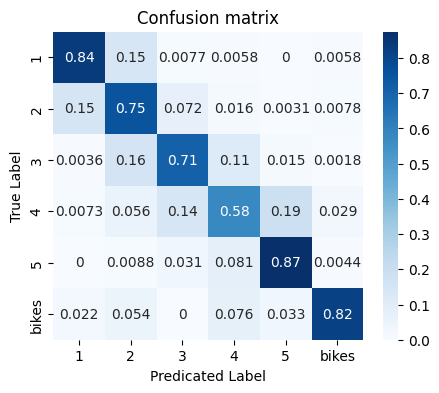

In [12]:
SHAPE_LABELS = [1,2,3,4,5,"bikes"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

#### Distribution of the train data

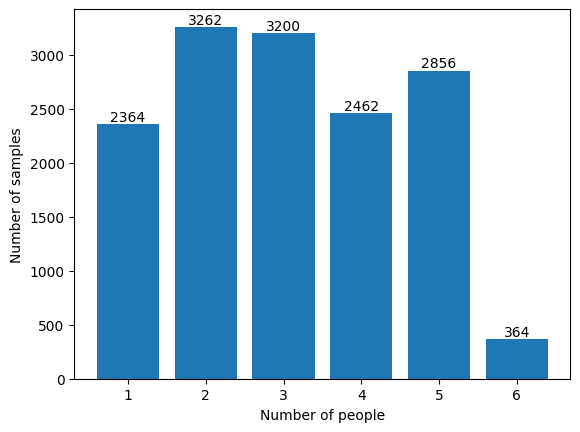

In [8]:
data_points = np.array([d.y.item() for d in train_graphs[0]])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
bikes = len(np.where(data_points  == 5)[0])

labels = [1,2,3,4,5, 6]
sample_num = [zeros, ones, twos, threes, fours,bikes]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()

In [44]:
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq']
features1 =  [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/3/3/*.csv")]
fnum_list = [feat["current_frame"][0] for feat in features1]
first = np.array([feat["seq"][0] == 0 for feat in features1])
first = np.where(first)[0]
fnum_list = [fnum_list[i] for i in first]
features1 = [features1[i] for i in first]
fnum = np.array(fnum_list)
print(len(fnum))
unique, counts = np.unique(fnum, return_counts=True)
dict_fnum = dict(zip(unique, counts))
multiple = {k: v for k, v in dict_fnum.items() if v > 1 }
print(len(unique))
print(multiple)
mul = list(multiple.keys())[4]
print(mul)
print(fnum_list.index(mul))
print(fnum_list.index(mul) + fnum_list[fnum_list.index(mul)+1:].index(mul))
identity = [features1[fnum_list.index(mul)], features1[fnum_list.index(mul) + fnum_list[fnum_list.index(mul)+1:].index(mul)+1]]
print(identity)

3879
3747
{85629.0: 2, 85631.0: 2, 85633.0: 2, 85635.0: 2, 85637.0: 2, 85639.0: 2, 85649.0: 2, 85663.0: 2, 85893.0: 2, 85895.0: 2, 85897.0: 2, 85899.0: 2, 85901.0: 2, 85903.0: 2, 86071.0: 2, 86081.0: 2, 86083.0: 2, 86085.0: 2, 86087.0: 2, 86089.0: 2, 86091.0: 2, 86093.0: 2, 86463.0: 2, 86465.0: 2, 86467.0: 2, 86469.0: 2, 86471.0: 2, 110425.0: 2, 110427.0: 2, 110429.0: 2, 110431.0: 2, 110433.0: 2, 110435.0: 2, 110437.0: 2, 110449.0: 2, 110451.0: 2, 110453.0: 2, 110455.0: 2, 110457.0: 2, 110459.0: 2, 110461.0: 2, 110463.0: 2, 110805.0: 2, 110807.0: 2, 110809.0: 2, 110819.0: 2, 110829.0: 2, 110831.0: 2, 110833.0: 2, 110835.0: 2, 110837.0: 2, 110845.0: 2, 110847.0: 2, 111185.0: 2, 111187.0: 2, 111189.0: 2, 111191.0: 2, 111201.0: 2, 111203.0: 2, 111211.0: 2, 111213.0: 2, 111215.0: 2, 111217.0: 2, 111219.0: 2, 111377.0: 2, 111563.0: 2, 111565.0: 2, 111567.0: 2, 111569.0: 2, 111571.0: 2, 111581.0: 2, 111589.0: 2, 111591.0: 2, 111593.0: 2, 111945.0: 2, 111947.0: 2, 111949.0: 2, 111951.0: 2, 11

In [3]:
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq']
features1 =  [(pd.read_csv(filename, names=column_names, header=None, dtype=np.float64), filename[14:19]) for filename in glob.glob("data/3/3/*.csv")]

In [4]:
from collections import defaultdict
result = defaultdict(list)

for i in range(len(features1)):
    current = features1[i]
    result[current[1]].append(current[0])
            
for k, v in result.items():
    result[k] = pd.concat(v)


print('z')

z


In [5]:
max_frame = -10
for k, v in result.items():
    shift = max_frame+10
    v["current_frame"] += shift
    max_frame = max(v["current_frame"])
    print(max_frame)
print('z')

114171.0
229228.0
333035.0
z


In [6]:
f = pd.concat([v for _, v in result.items()])

In [8]:
print(f.shape)

(1191142, 8)


In [9]:
features3: DataFrame = pd.concat(
        [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/3/3/*.csv")])
print(features3.shape)

(1191142, 8)


In [11]:
result = defaultdict(list)
print(result)

defaultdict(<class 'list'>, {})


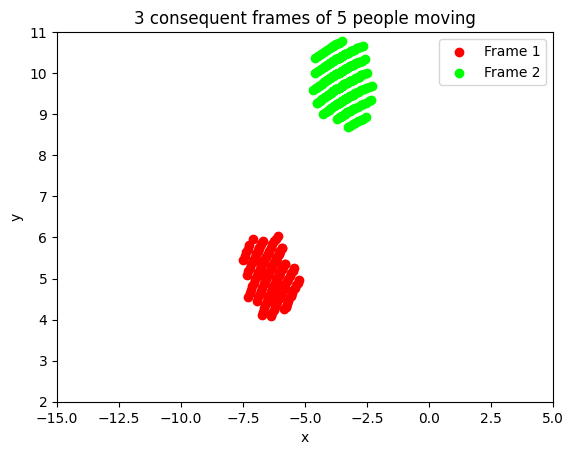

In [43]:
data = [frame.to_numpy() for frame in identity]
frame_num = 0
frame1 = data[frame_num]
frame2 = data[frame_num+1]

plt.scatter(frame1[:, 5], frame1[:, 4], c="red", label="Frame 1")
plt.scatter(frame2[:, 5], frame2[:, 4], c="lime", label="Frame 2")

plt.legend()
plt.title("3 consequent frames of 5 people moving")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(-15, 5)
plt.ylim(2, 11)
plt.show()